# 学習

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データの前処理
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
])

# MNISTデータセットの読み込み
original_train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
original_test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)


In [2]:
# クラス1のデータのみ抽出
train_dataset = [data for data in original_train_dataset if data[1] == 1]
test_dataset = [data for data in original_test_dataset if data[1] == 1]

In [3]:
len(train_dataset)

6742

In [4]:
len(test_dataset)

1135

In [8]:

# DataLoaderの作成
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoderモデルの定義
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # エンコーダ部分
        self.encoder = nn.Sequential(
            nn.Linear(14 * 14, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            nn.ReLU(),
        )
        
        # デコーダ部分
        self.decoder = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 14 * 14),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# モデルのインスタンス化とデバイスへの移動
model = Autoencoder().to(device)

# 損失関数と最適化アルゴリズムの定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習の実行
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = 0.0
    
    # モデルを訓練モードに設定
    model.train()
    
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        
        # 順伝播と逆伝播の計算
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images.view(images.size(0), -1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    # エポックごとの損失を出力
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

# テストデータでの評価
test_loss = 0.0

# モデルを評価モードに設定
model.eval()

def loss_fn(model, images):
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images.view(images.size(0), -1))
    return loss

with torch.no_grad():
    for data in test_loader:
        images, _ = data
        loss = loss_fn(model, images)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/10, Training Loss: 0.0375
Epoch 2/10, Training Loss: 0.0077
Epoch 3/10, Training Loss: 0.0038
Epoch 4/10, Training Loss: 0.0024
Epoch 5/10, Training Loss: 0.0017
Epoch 6/10, Training Loss: 0.0013
Epoch 7/10, Training Loss: 0.0010
Epoch 8/10, Training Loss: 0.0009
Epoch 9/10, Training Loss: 0.0008
Epoch 10/10, Training Loss: 0.0007
Test Loss: 0.0007


# 異常検知

In [18]:
label1_data = test_dataset[:100]

In [19]:
label7_data = [data for data in original_test_dataset if data[1] == 7][:100]

In [20]:
target_data = label1_data + label7_data

In [21]:
losses = [ loss_fn(model, d[0]).item() for d in target_data]

In [22]:
import pandas as pd

df = pd.DataFrame(
    data = {
        "loss": losses
    }
)

<Axes: >

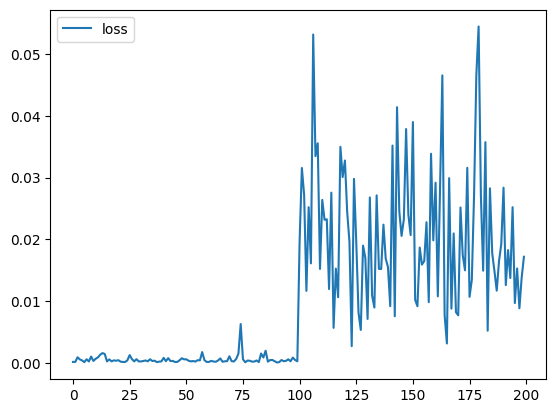

In [23]:
df.plot()